 # <center> <b>  STROKE PREDICTION </b> </center> 

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

# load imblearn libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (12, 6)
sns.set(context="paper", font="monospace")

## Data Preparation and EDA

In [3]:
data = pd.read_csv('stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Specify hypertension and heart_disease columns categories

In [5]:
mapper = {0: 'No', 1: 'Yes'}
def encode(val):
    return mapper[val]

for col in ['hypertension','heart_disease']:    
    data[col] = data[col].apply(encode)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 479.2+ KB


Drop axis column

In [7]:
data.drop('id', axis=1, inplace=True)

In [8]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Fill null values in bmi column with mean value 

In [9]:
data['bmi'].fillna(data['bmi'].mean(), inplace=True)
data.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Target Feature EDA

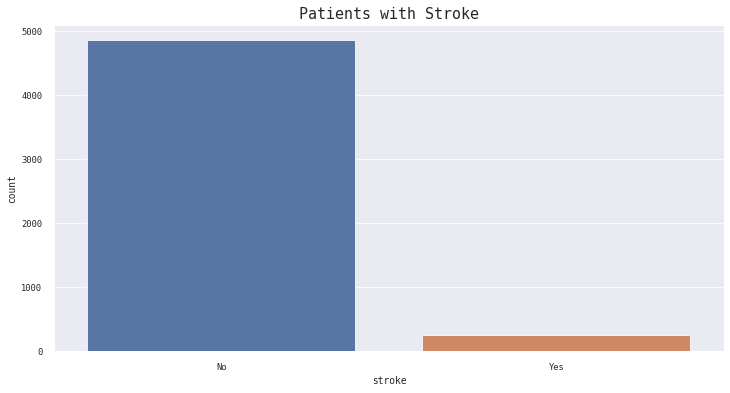

In [10]:
sns.countplot('stroke', data=data)
plt.xticks([0,1], ['No', 'Yes'])
plt.title('Patients with Stroke', size=15)
plt.savefig('stroke_count.png');

In [11]:
perc = data['stroke'].value_counts(normalize=True)*100
perc 

0    95.127202
1     4.872798
Name: stroke, dtype: float64

In [12]:
perc.keys()

Int64Index([0, 1], dtype='int64')

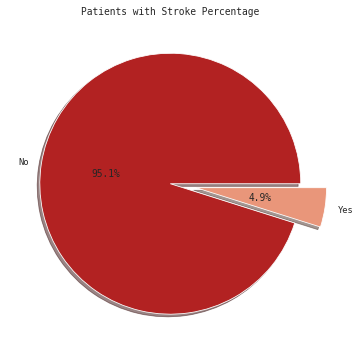

In [13]:
labels = perc.keys() # get labels from perc
# autopct allows formatting percentage string
plt.pie(x=perc, autopct="%1.1f%%", explode=[0,0.2], labels=['No', 'Yes'], 
        pctdistance=0.5, shadow=True, colors=['firebrick','DarkSalmon'])
plt.title("Patients with Stroke Percentage")
plt.savefig('stroke_pie_chart.png');

**Observation:** The pie plot and count plot shows that there is high imbalance in the target variable. About $4.9\%$ of patients had a stroke, while $95.1\%$ did not.

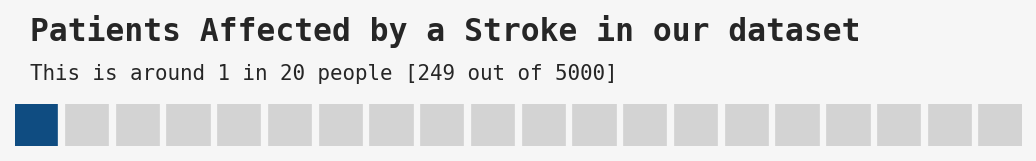

In [14]:
from pywaffle import Waffle

fig = plt.figure(figsize=(7, 2),dpi=150, facecolor="#f6f6f6",
    FigureClass=Waffle,
    rows=1,
    values=[1, 19],
    colors=['#0f4c81', "lightgray"],
    characters='',
    font_size=20,vertical=True,
)

fig.text(0.035,0.78,'Patients Affected by a Stroke in our dataset',fontsize=15,fontweight='bold')
fig.text(0.035,0.65,'This is around 1 in 20 people [249 out of 5000]',fontsize=10)

plt.show()

**Observation:** Strokes are still relatively rare

### Object and Numerical columns EDA


Get categorical and numerical features 

In [15]:
cat_feat = list(data.select_dtypes(exclude = np.number).columns)
num_feat = list(data.select_dtypes(exclude = object).columns)

In [16]:
print(cat_feat)

['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [17]:
num_feat

['age', 'avg_glucose_level', 'bmi', 'stroke']

Drop stroke column from numerical features

In [18]:
num_feat.pop()
num_feat

['age', 'avg_glucose_level', 'bmi']

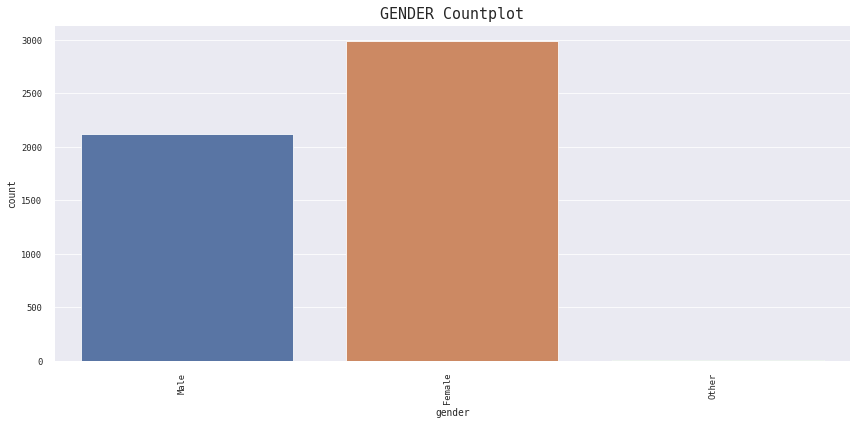

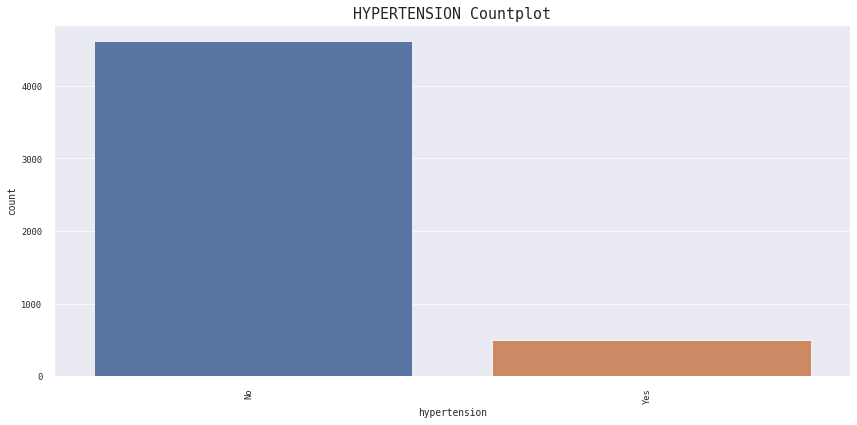

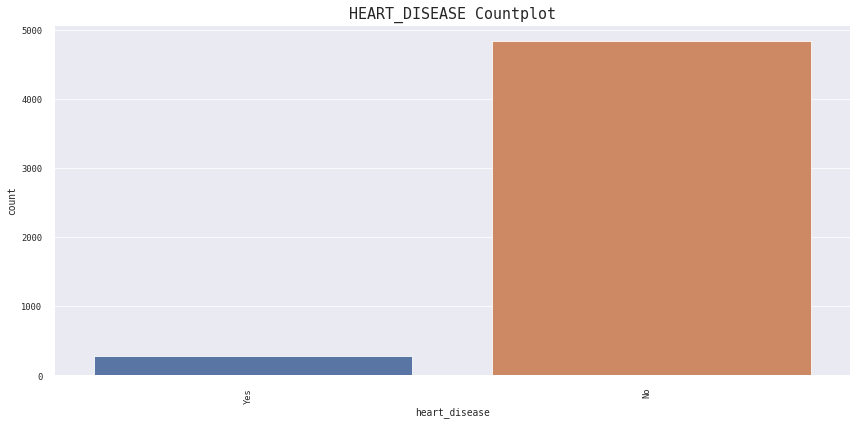

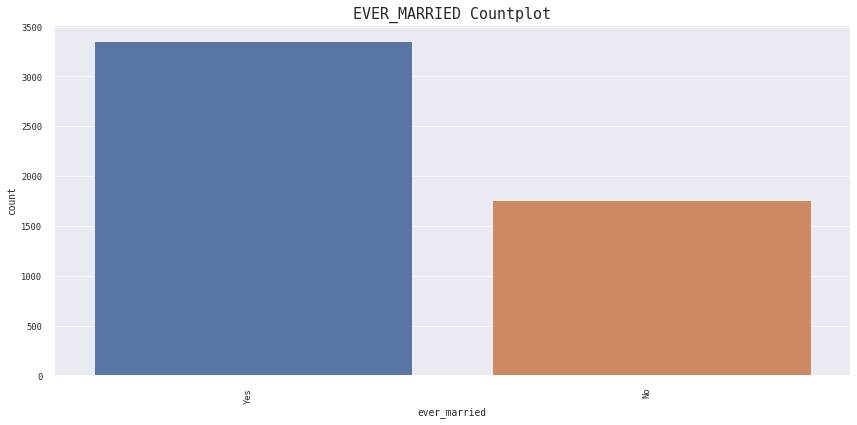

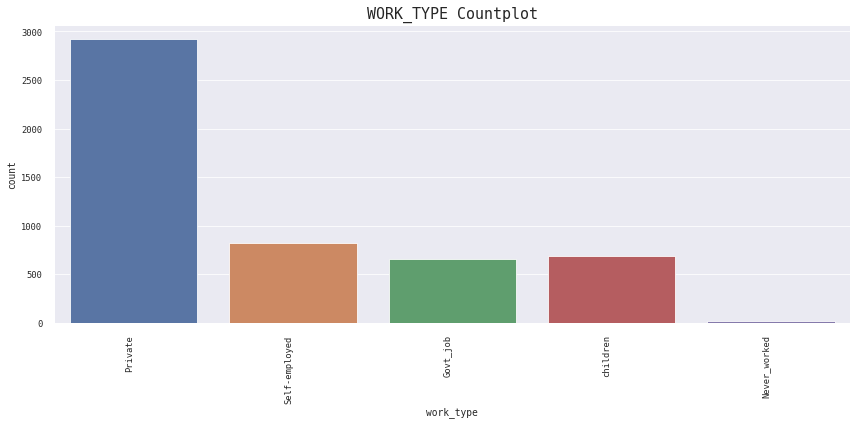

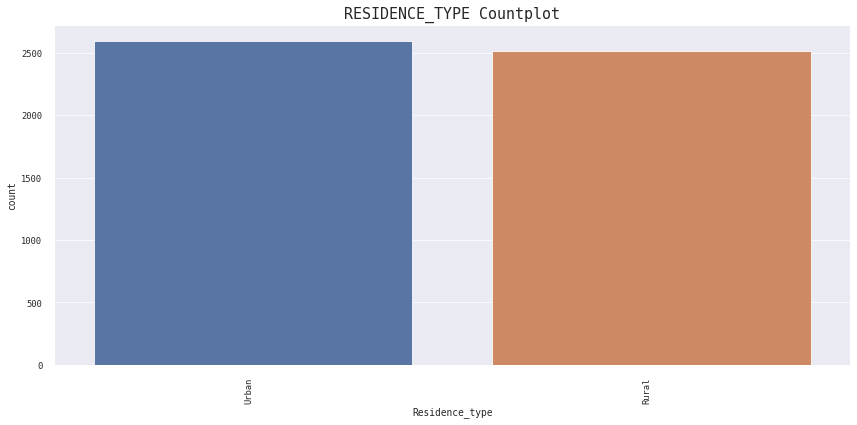

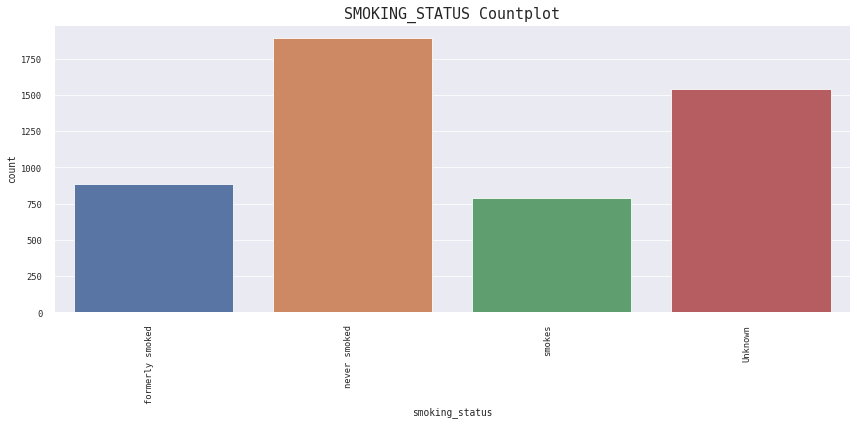

In [19]:
for col in cat_feat:
#     plt.figure(figsize=(12,5))
    g = sns.countplot(x=col, data=data)
    g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
    plt.title(col.upper()+' Countplot', size=15)
    plt.tight_layout()
    plt.show()

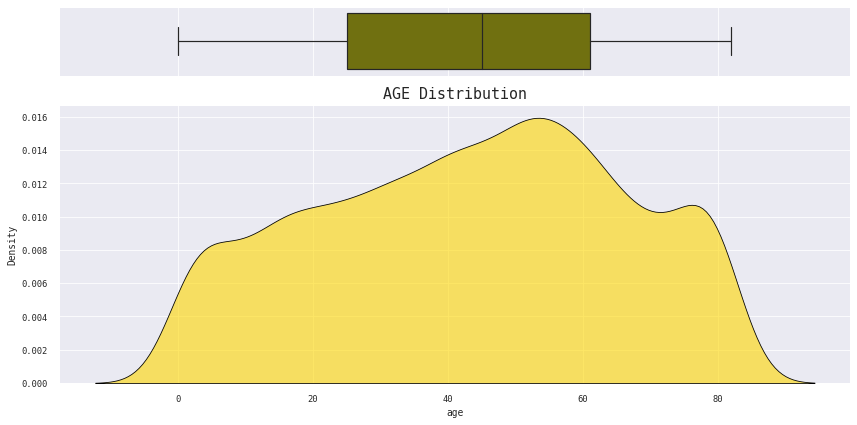

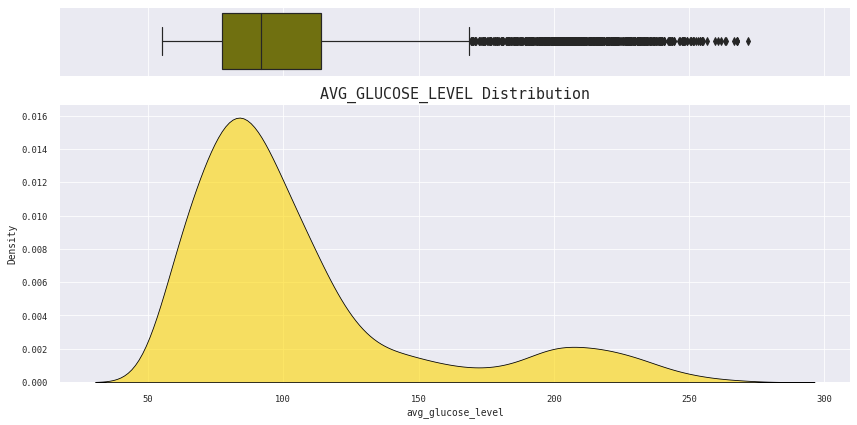

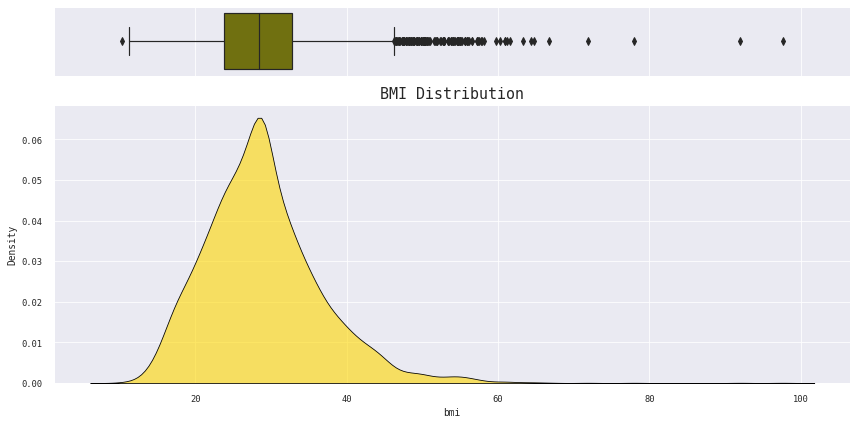

In [20]:
for col in data[num_feat]:
    ax = [None for i in range(2)]
    # set 2 subplots and set ratio of plots 
    f, (ax[0], ax[1]) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.20, .80)
                                        })   
    g1 = sns.boxplot(col, ax=ax[0], data=data, color='olive') # boxplot
    g1.set(xlabel=None) # remove x axis label for boxplot
    g2 = sns.kdeplot(data[col], ax=ax[1], shade=True, color='gold', alpha=0.6, 
                     zorder=3, edgecolor='black') # distribution plot
    plt.title(col.upper()+' Distribution', size=15)
    plt.tight_layout()
    plt.show()

**Observation:** Most patients are between $40$ to $60$ years old, and have bmi mostly between $25$ and $35$. Lots of outliers in average glucose level and bmi columns.

### Analyis of Categorical Variables and Target

In [21]:
stroke = data['stroke'].apply(encode)
stroke.head()

0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: stroke, dtype: object

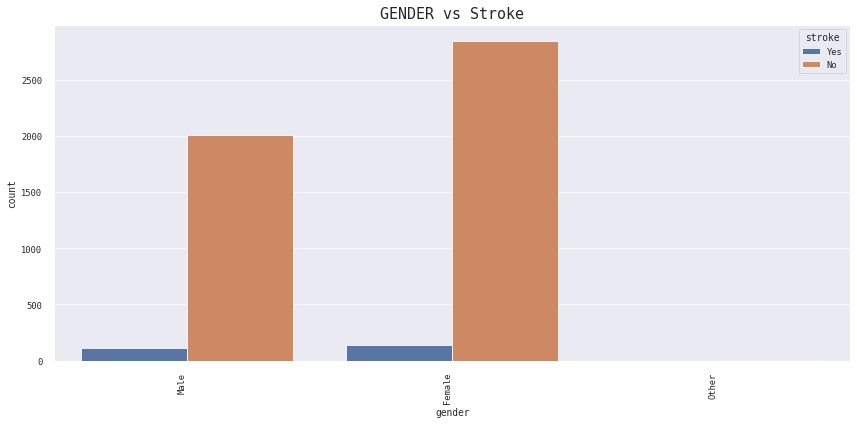

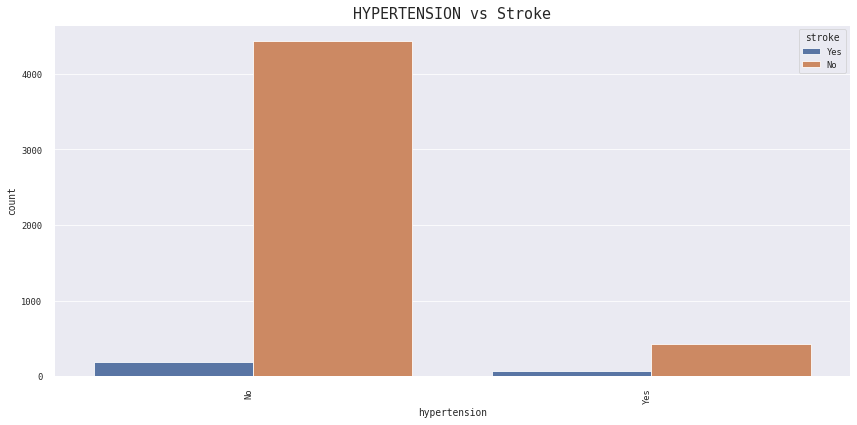

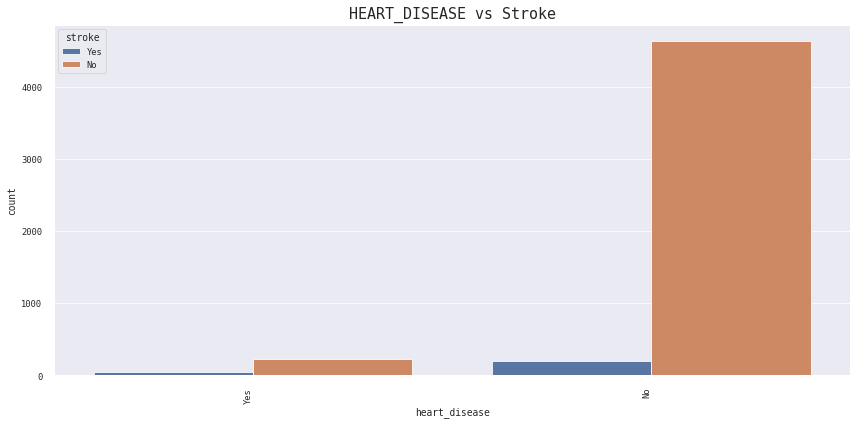

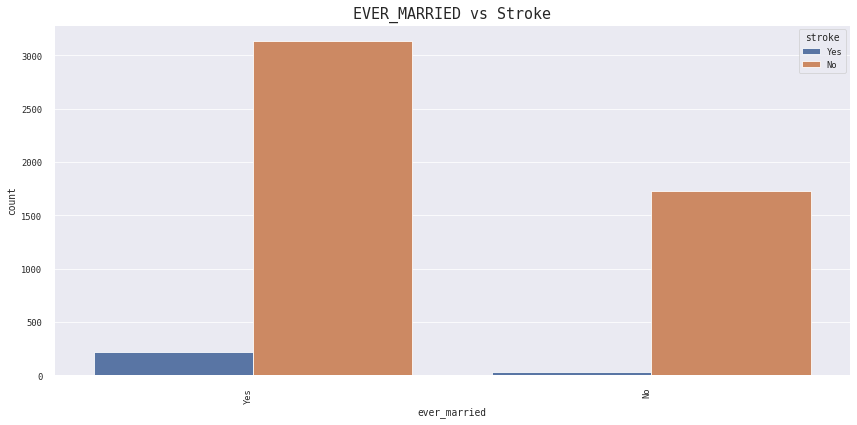

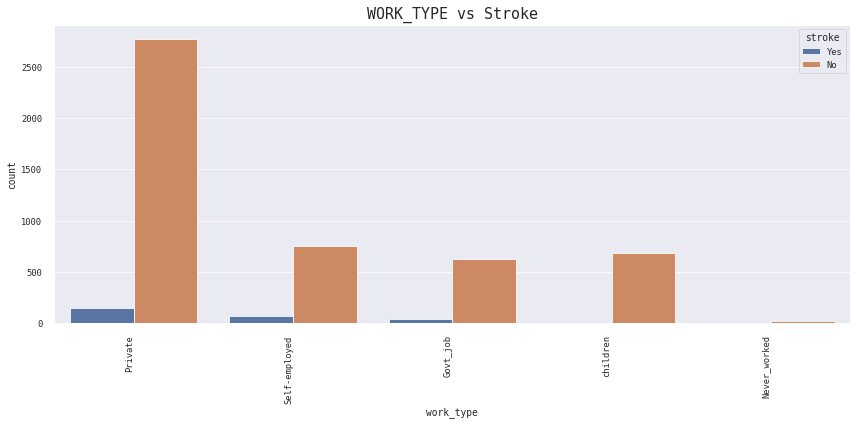

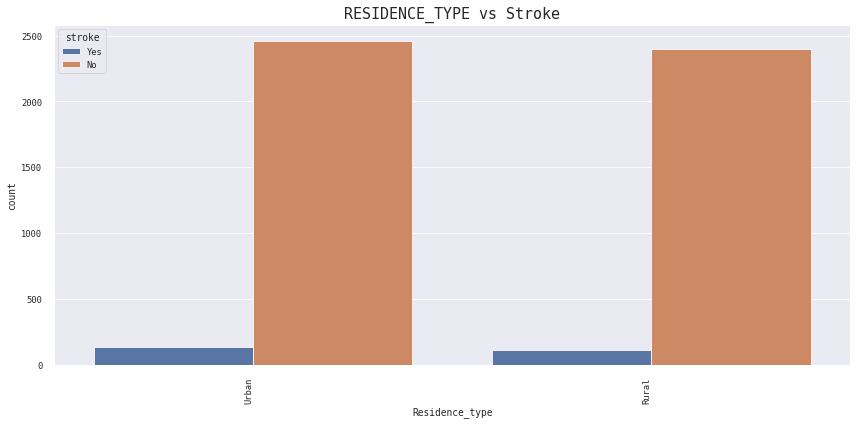

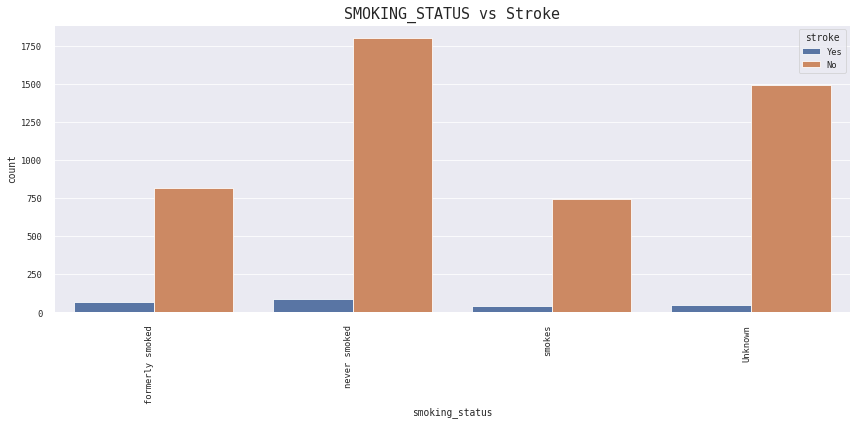

In [22]:
for col in cat_feat:
#     plt.figure(figsize=(12,5))
    g = sns.countplot(x=col, data=data, hue=stroke)
    g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
    plt.title(col.upper()+' vs Stroke', size=15)
    plt.tight_layout()
    plt.show() 

### Analyis of Continuous Variables and Target

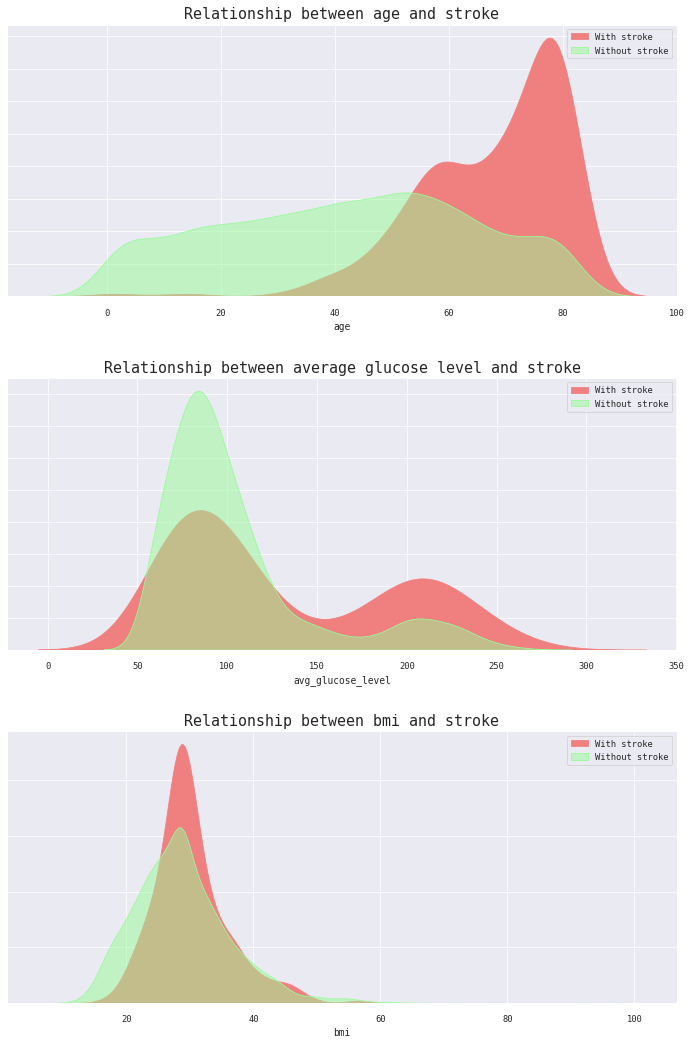

In [23]:
fig=plt.figure(figsize=(12,18),facecolor='white')

ax=[None for i in range(3)]
gs=fig.add_gridspec(3,1)
gs.update(wspace=0, hspace=0.3)

ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[1,0])
ax[2]=fig.add_subplot(gs[2,0])

# first plot
sns.kdeplot(data=data[data.stroke==1],x='age',ax=ax[0],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=data[data.stroke==0],x='age',ax=ax[0],shade=True,color='palegreen',alpha=0.5)
ax[0].set_title('Relationship between age and stroke', fontsize=15)
# second plot
sns.kdeplot(data=data[data.stroke==1],x='avg_glucose_level',ax=ax[1],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=data[data.stroke==0],x='avg_glucose_level',ax=ax[1],shade=True,color='palegreen',alpha=0.5)
ax[1].set_title('Relationship between average glucose level and stroke', fontsize=15)
# third plot
sns.kdeplot(data=data[data.stroke==1],x='bmi',ax=ax[2],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=data[data.stroke==0],x='bmi',ax=ax[2],shade=True,color='palegreen',alpha=0.5)
ax[2].set_title('Relationship between bmi and stroke', fontsize=15)
plt.tight_layout()
for i in range(3):
    ax[i].legend(labels=['With stroke', 'Without stroke'])
    ax[i].set_yticklabels('')
    ax[i].set_ylabel('')

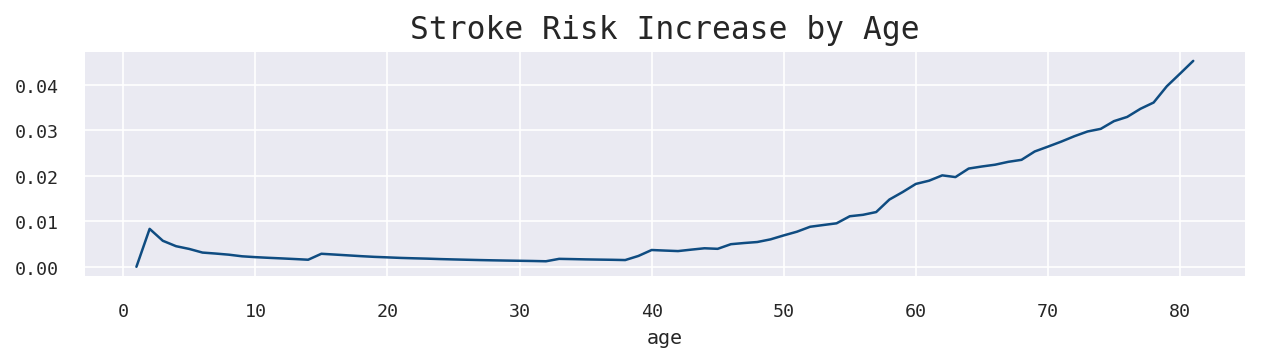

In [24]:
fig = plt.figure(figsize=(10, 5), dpi=150)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.11, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])

data['age'] = data['age'].astype(int)

rate = []
for i in range(data['age'].min(), data['age'].max()):
    rate.append(data[data['age'] < i]['stroke'].sum() / len(data[data['age'] < i]['stroke']))

sns.lineplot(data=rate, color='#0f4c81', ax=ax0)
ax0.set_xlabel('age') 
ax0.set_title('Stroke Risk Increase by Age', fontsize=15)
plt.show()

**Observation:** The older a patient is, the more likely he/she has a stroke.

In [25]:
str_only = data[data['stroke'] == 1]
no_str_only = data[data['stroke'] == 0]

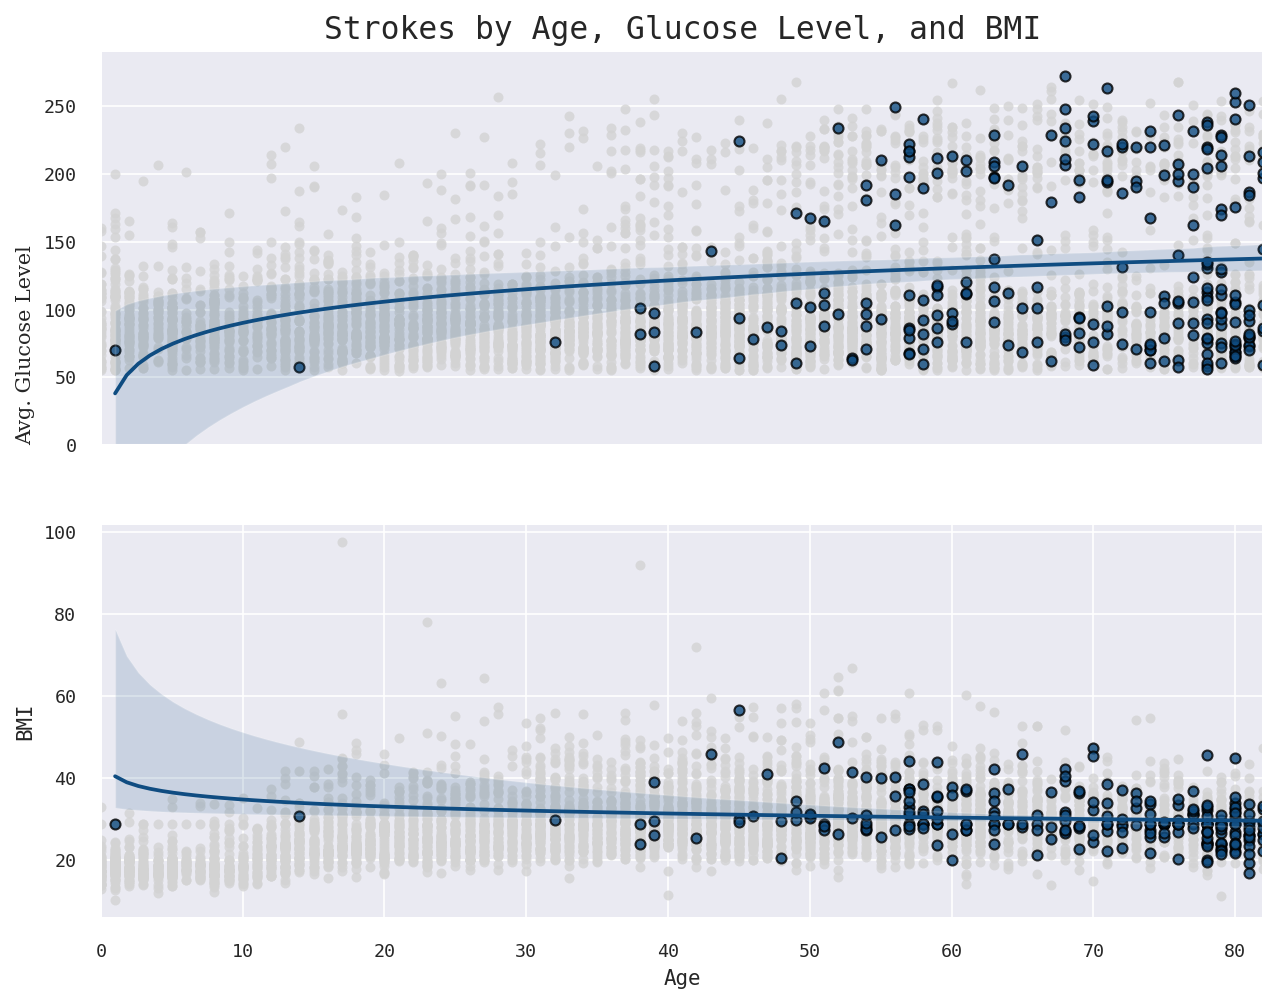

In [26]:
# Setting up figure and axes

fig = plt.figure(figsize=(10,16),dpi=150) 
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.5, hspace=0.2)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[1, 0:2]) 


# glucose
sns.regplot(no_str_only['age'],y=no_str_only['avg_glucose_level'],  
            color='lightgray',
            logx=True,
            ax=ax0)
sns.regplot(str_only['age'],y=str_only['avg_glucose_level'],  
            color='#0f4c81',
            logx=True,scatter_kws={'edgecolors':['black'], 
                                              'linewidth': 1},
            ax=ax0)

ax0.set(ylim=(0, None))
ax0.set_xlabel(" ",fontsize=12,fontfamily='serif')
ax0.set_ylabel("Avg. Glucose Level",fontsize=10,fontfamily='serif',loc='bottom')

ax0.tick_params(axis='x', bottom=False)
ax0.get_xaxis().set_visible(False)

# bmi
sns.regplot(no_str_only['age'],y=no_str_only['bmi'],  
            color='lightgray',
            logx=True,
            ax=ax1)

sns.regplot(str_only['age'],y=str_only['bmi'],  
            color='#0f4c81', scatter_kws={'edgecolors':['black'], 
                                              'linewidth': 1},
            logx=True,
            ax=ax1)

ax1.set_xlabel("Age",fontsize=10)
ax1.set_ylabel("BMI",fontsize=10)
ax0.set_title('Strokes by Age, Glucose Level, and BMI', fontsize=15);

### Univariate analysis of categorical variables

#### Gender

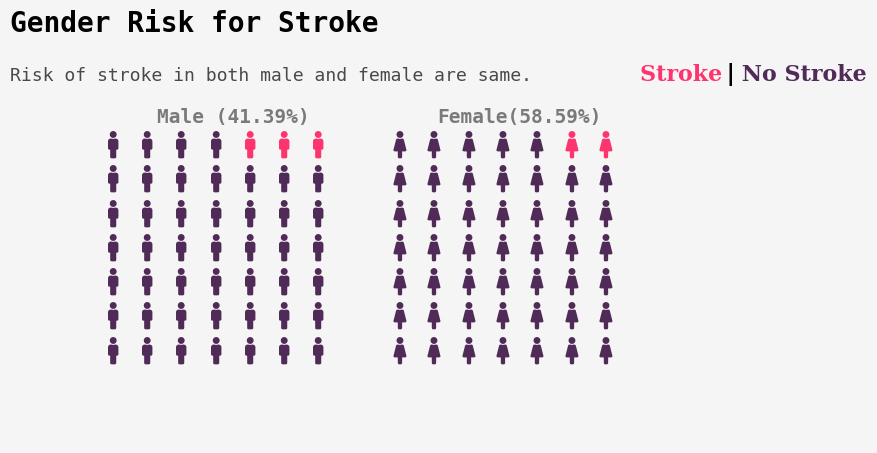

In [27]:
stroke_gen = data[data['stroke'] == 1]['gender'].value_counts()
healthy_gen = data[data['stroke'] == 0]['gender'].value_counts()

female = data['gender'].value_counts(normalize=True).values[0]
male =  data['gender'].value_counts(normalize=True).values[1]

stroke_female = int(round (stroke_gen.values[0] / female * 100, 0))
stroke_male = int(round( stroke_gen.values[1] / male *100, 0))
healthy_female = int(round(healthy_gen.values[0] / female * 100, 0))
healthy_male = int(round(healthy_gen.values[1] / male *100, 0))

female_per = round(female * 100, 2)
male_per = round(male * 100, 2)



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'121':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [healthy_male,stroke_male],
                            'colors' : ['#512b58','#fe346e'],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'male',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          '122' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[healthy_female,stroke_female],         
                              'colors' : ['#512b58','#fe346e'],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'female',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)
fig.text(0., 0.8, 'Gender Risk for Stroke', {'size':20, 'color':'black', 'weight':'bold'})
fig.text(0., 0.73, 'Risk of stroke in both male and female are same. ', {'size':13, 'color':'black', 'weight':'normal'}, alpha = 0.7)
fig.text(0.24, 0.22, 'ooo', {'size':16,'weight':'bold' ,'color':'#f6f5f5'})
fig.text(0.65, 0.22, 'ooo', {'size':16,'weight':'bold', 'color':'#f6f5f5'})
# fig.text(0.23, 0.28, '{}%'.format(healthy_male), {'size':20,'weight':'bold' ,'color':'#512b58'},alpha = 1,)
# fig.text(0.65, 0.28, '{}%'.format(healthy_female), {'size':20,'weight':'bold', 'color':'#512b58'}, alpha = 1)
fig.text(0.21, 0.67, 'Male ({}%)'.format(male_per), {'size':14,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.61, 0.67, 'Female({}%)'.format(female_per), {'size':14,'weight':'bold', 'color':'black'}, alpha = 0.5)

fig.text(0.9,0.73, 'Stroke ', {'font': 'Serif','weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(1.02,0.73, '| ', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.035,0.73, ' No Stroke', {'font': 'Serif','weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)

fig.show()

#### Hypertension

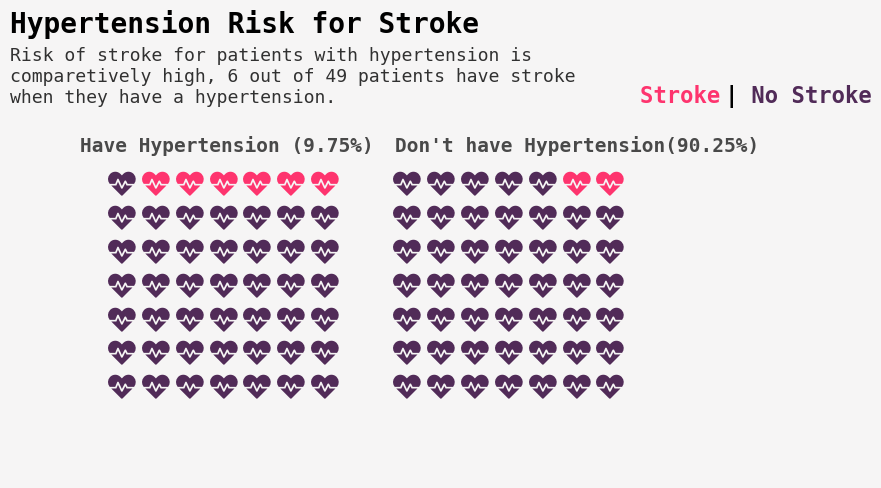

In [28]:
stroke_hyper = data[data['stroke'] == 1]['hypertension'].value_counts()
healthy_hyper = data[data['stroke'] == 0]['hypertension'].value_counts()

no = data['hypertension'].value_counts(normalize=True).values[0]
yes =  data['hypertension'].value_counts(normalize=True).values[1]

stroke_no = int(round (stroke_hyper.values[0] / no * 100, 0))
stroke_yes = int(round( stroke_hyper.values[1] / yes *100, 0))
healthy_no = int(round(healthy_hyper.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_hyper.values[1] / yes *100, 0))

no_per = round(no * 100, 2)
yes_per = round(yes * 100, 2)


fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'121':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_yes,healthy_yes],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'heartbeat',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':1,
                              'starting_location': 'NE'
                          },
                          
                          '122' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_no,healthy_no],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y':0.005,
                              'icons' : 'heartbeat',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':1,
                              'starting_location': 'NE'
                                                      
                           }
                         },
                   
)

fig.text(0., 0.85, 'Hypertension Risk for Stroke', {'size':20, 'color':'black', 'weight':'bold'})
fig.text(0., 0.75, 'Risk of stroke for patients with hypertension is \ncomparetively high, 6 out of 49 patients have stroke \nwhen they have a hypertension. ', 
         {'size':13, 'color':'black', 'weight':'normal'}, alpha = 0.8)
fig.text(0.24, 0.22, 'ooo', {'size':16,'weight':'bold' ,'color':'#f6f5f5'})
fig.text(0.65, 0.22, 'ooo', {'size':16,'weight':'bold', 'color':'#f6f5f5'})
# fig.text(0.23, 0.28, '{}%'.format(healthy_yes), {'size':20,'weight':'bold' ,'color':'#512b58'},alpha = 1)
# fig.text(0.63, 0.28, '{}%'.format(healthy_no), {'size':20,'weight':'bold', 'color':'#512b58'}, alpha = 1)
fig.text(0.1, 0.68, 'Have Hypertension ({}%)'.format(yes_per), {'size':14,'weight':'bold' ,'color':'black'},alpha = 0.7,)
fig.text(0.55, 0.68, "Don't have Hypertension({}%)".format(no_per), {'size':14,'weight':'bold', 'color':'black'}, alpha = 0.7)

fig.text(0.90,0.75, 'Stroke ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(1.02,0.75, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.04,0.75, ' No Stroke', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)

fig.show()

#### Heart Disease

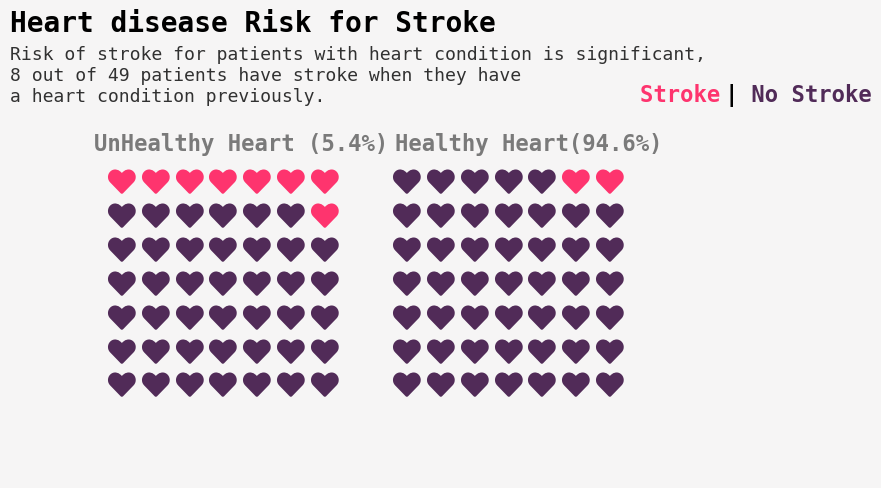

In [29]:
stroke_hyper = data[data['stroke'] == 1]['heart_disease'].value_counts()
healthy_hyper = data[data['stroke'] == 0]['heart_disease'].value_counts()

no = data['heart_disease'].value_counts(normalize=True).values[0]
yes =  data['heart_disease'].value_counts(normalize=True).values[1]

stroke_no = int(round (stroke_hyper.values[0] / no * 100, 0))
stroke_yes = int(round( stroke_hyper.values[1] / yes *100, 0))
healthy_no = int(round(healthy_hyper.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_hyper.values[1] / yes *100, 0))

no_per = round(no * 100, 2)
yes_per = round(yes* 100, 2)

fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'121':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_yes,healthy_yes],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'heart',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                          },
                          
                          '122' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_no,healthy_no],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y':0.005,
                              'icons' : 'heart',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                                                      
                           }
                         },
                   
)

fig.text(0., 0.85, 'Heart disease Risk for Stroke', {'size':20, 'color':'black', 'weight':'bold'})
fig.text(0., 0.75, 'Risk of stroke for patients with heart condition is significant,\n8 out of 49 patients have stroke when they have \na heart condition previously. ', {'size':13, 'color':'black', 'weight':'normal'}, alpha = 0.8)
fig.text(0.24, 0.22, 'ooo', {'size':16,'weight':'bold' ,'color':'#f6f5f5'})
fig.text(0.65, 0.22, 'ooo', {'size':16,'weight':'bold', 'color':'#f6f5f5'})
# fig.text(0.25, 0.27, '{}%'.format(healthy_yes), {'size':20,'weight':'bold' ,'color':'#2c003e'},alpha = 1)
# fig.text(0.65, 0.27, '{}%'.format(healthy_no), {'size':20,'weight':'bold', 'color':'#2c003e'}, alpha = 1)
fig.text(0.12, 0.68, 'UnHealthy Heart ({}%)'.format(yes_per), {'size':16,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.55, 0.68, "Healthy Heart({}%)".format(no_per), {'size':16,'weight':'bold', 'color':'black'}, alpha = 0.5)

fig.text(0.9,0.75, 'Stroke ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(1.02,0.75, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.04,0.75, ' No Stroke', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)

fig.show() 

#### Marraige

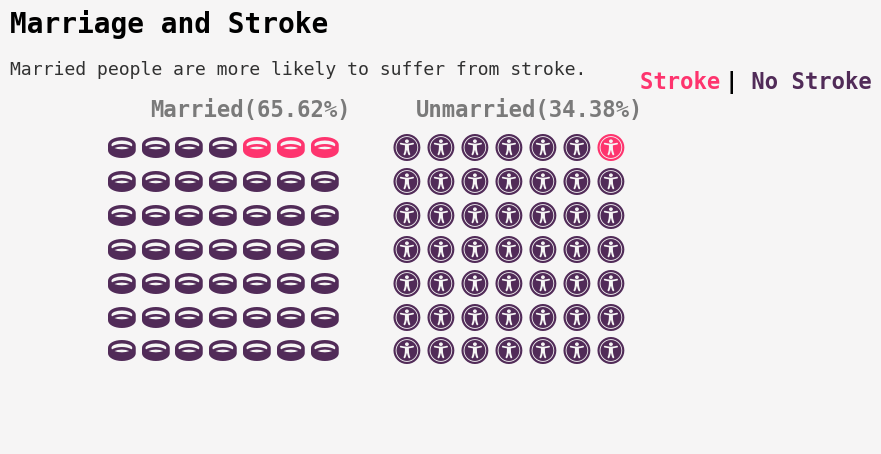

In [30]:
stroke_mary = data[data['stroke'] == 1]['ever_married'].value_counts()
healthy_mary = data[data['stroke'] == 0]['ever_married'].value_counts()

yes = data['ever_married'].value_counts(normalize=True).values[0]
no =  data['ever_married'].value_counts(normalize=True).values[1]

stroke_no = int(round (stroke_mary.values[1] / no * 100, 0))
stroke_yes = int(round( stroke_mary.values[0] / yes *100, 0))
healthy_no = int(round(healthy_mary.values[1] / no * 100, 0))
healthy_yes = int(round(healthy_mary.values[0] / yes *100, 0))

no_per = round(no * 100, 2)
yes_per = round(yes * 100, 2)

fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'121':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_yes,healthy_yes],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'ring',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                          },
                          
                          '122' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_no,healthy_no],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y':0.005,
                              'icons' : 'universal-access',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                                                      
                           }
                         },
                   
)

fig.text(0., 0.8, 'Marriage and Stroke', { 'size':20, 'color':'black', 'weight':'bold'})
fig.text(0., 0.74, 'Married people are more likely to suffer from stroke.', { 'size':13, 'color':'black', 'weight':'normal'}, alpha = 0.8)
fig.text(0.24, 0.22, 'ooo', { 'size':16,'weight':'bold' ,'color':'#f6f5f5'}) 
fig.text(0.65, 0.22, 'ooo', { 'size':16,'weight':'bold', 'color':'#f6f5f5'}) 
# fig.text(0.25, 0.28, '{}%'.format(healthy_yes), { 'size':20,'weight':'bold' , 'color':'#2c003e'}, alpha = 1,)
# fig.text(0.65, 0.28, '{}%'.format(healthy_no), { 'size':20,'weight':'bold', 'color':'#2c003e'}, alpha = 1)
fig.text(0.20, 0.68, 'Married({}%)'.format(yes_per), { 'size':16,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.58, 0.68, "Unmarried({}%)".format(no_per), { 'size':16,'weight':'bold', 'color':'black'}, alpha = 0.5)

fig.text(0.9,0.72, 'Stroke ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(1.02,0.72, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.04,0.72, ' No Stroke', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)


fig.show()

#### Residence Type

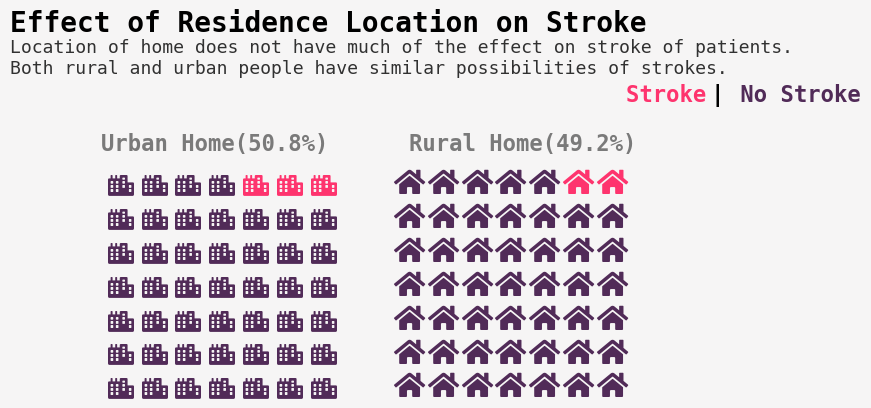

In [31]:
stroke_home = data[data['stroke'] == 1]['Residence_type'].value_counts()
healthy_home= data[data['stroke'] == 0]['Residence_type'].value_counts()

urban = data['Residence_type'].value_counts(normalize=True).values[0]
rural =  data['Residence_type'].value_counts(normalize=True).values[1]

stroke_urban = int(round (stroke_home.values[0] / urban * 100, 0))
stroke_rural= int(round( stroke_home.values[1] / rural *100, 0))
healthy_urban = int(round(healthy_home.values[0] / urban * 100, 0))
healthy_rural = int(round(healthy_home.values[1] / rural *100, 0))

urban_per = round(urban * 100, 2)
rural_per = round(rural* 100, 2)

fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'121':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_urban,healthy_urban],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'city',
                              'icon_legend': False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                          },
                          
                          '122' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_rural,healthy_rural],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y':0.005,
                              'icons' : 'home',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                                                      
                           }
                         },
                   
)

fig.text(0., 0.85, 'Effect of Residence Location on Stroke', { 'size':20, 'color':'black', 'weight':'bold'})
fig.text(0., 0.79, 'Location of home does not have much of the effect on stroke of patients.\nBoth rural and urban people have similar possibilities of strokes.', { 'size':13, 'color':'black', 'weight':'normal'}, alpha =0.8)

# fig.text(0.23, 0.28, '{}%'.format(healthy_urban), {'size':20,'weight':'bold' ,'color':'#2c003e'},alpha = 1,)
# fig.text(0.68, 0.28, '{}%'.format(healthy_rural), {'size':20,'weight':'bold', 'color':'#2c003e'}, alpha = 1)
fig.text(0.13, 0.68, 'Urban Home({}%)'.format(urban_per), { 'size':16,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.57, 0.68, "Rural Home({}%)".format(rural_per), { 'size':16,'weight':'bold', 'color':'black'}, alpha = 0.5)

fig.text(0.88,0.75, 'Stroke ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(1,0.75, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.025,0.75, ' No Stroke', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)

fig.show()

#### Smokers

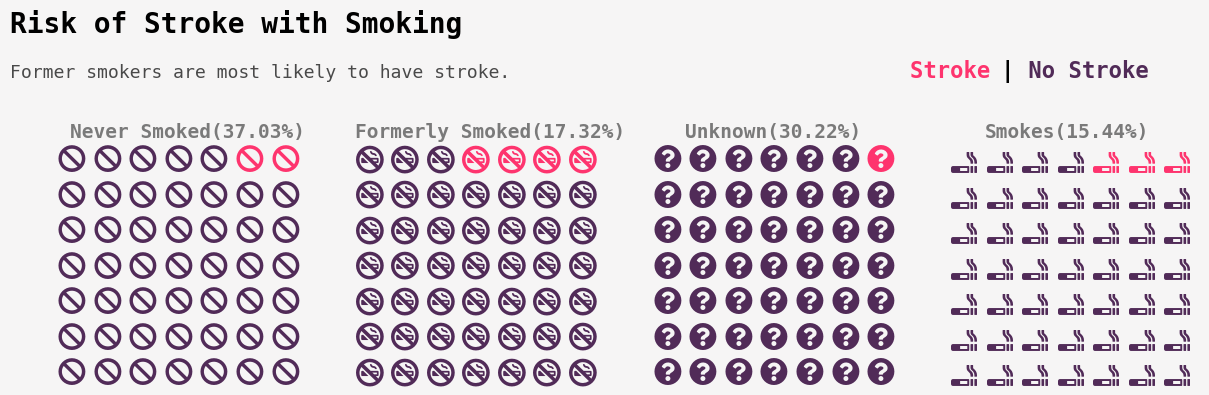

In [32]:
smoke = data['smoking_status'].value_counts(normalize=True)
stroke_smoke = data[data['stroke'] == 1]['smoking_status'].value_counts()
healthy_smoke = data[data['stroke'] == 0]['smoking_status'].value_counts()

never = smoke.values[0]
unknown =  smoke.values[1]
former = smoke.values[2]
smokes = smoke.values[3]

stroke_never = int(round (stroke_smoke.values[0] / never * 100, 0))
stroke_unknown = int(round( stroke_smoke.values[2]  / unknown *100, 0))
stroke_former = int(round (stroke_smoke.values[1]  / former * 100, 0))
stroke_smokes = int(round( stroke_smoke.values[3]  / smokes *100, 0))

healthy_never = int(round(healthy_smoke.values[0] / never * 100, 0))
healthy_unknown = int(round(healthy_smoke.values[1] / unknown *100, 0))
healthy_former = int(round(healthy_smoke.values[2] / former * 100, 0))
healthy_smokes = int(round(healthy_smoke.values[3]/ smokes *100, 0))

never_per = round(never * 100, 2)
unknown_per = round(unknown * 100, 2)
former_per = round(former * 100, 2)
smokes_per = round(smokes * 100, 2)



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (15,15),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'141':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_never,healthy_never],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'ban',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                          },
                          
                          '142' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_former,healthy_former],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y':0.005,
                              'icons' : 'smoking-ban',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                                                      
                           },
                          
                          '143':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_unknown,healthy_unknown],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'question-circle',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                          },
                          
                          '144' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_smokes,healthy_smokes],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.006,
                              'interval_ratio_y':0.006,
                              'icons' : 'smoking',
                              'icon_legend' :False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                                                      
                           }
                          
                         },
                   
)


fig.text(0.1, 0.65, 'Risk of Stroke with Smoking', { 'size':20, 'color':'black', 'weight':'bold'})
fig.text(0.1, 0.62, 'Former smokers are most likely to have stroke. ', { 'size':13, 'color':'black', 'weight':'normal'}, alpha = 0.7)

fig.text(0.14, 0.58, 'Never Smoked({}%)'.format(never_per), { 'size':14,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.33, 0.58, "Formerly Smoked({}%)".format(former_per), { 'size':14,'weight':'bold', 'color':'black'}, alpha = 0.5)
fig.text(0.55, 0.58, 'Unknown({}%)'.format(unknown_per), { 'size':14,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.75, 0.58, "Smokes({}%)".format(smokes_per), { 'size':14,'weight':'bold', 'color':'black'}, alpha = 0.5)

fig.text(0.7,0.62, 'Stroke ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(0.76,0.62, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(0.77,0.62, ' No Stroke', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)

fig.show()

#### Work

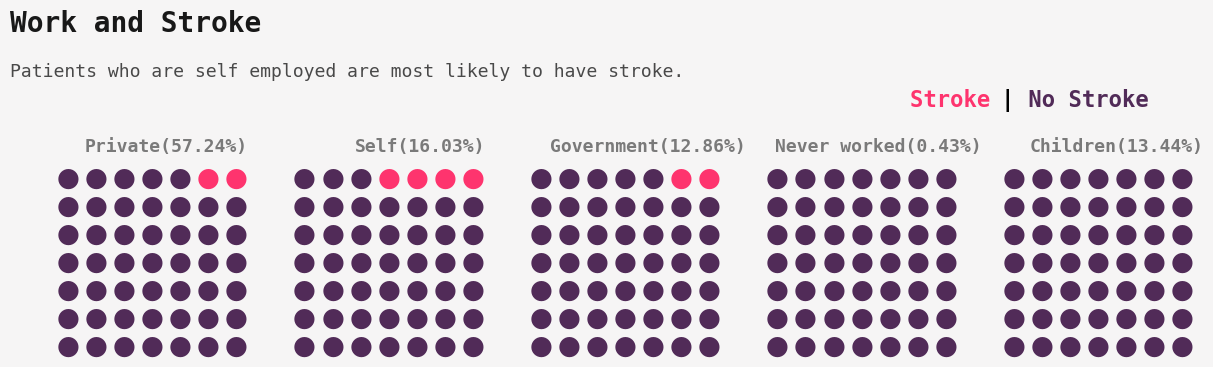

In [33]:
work = data['work_type'].value_counts(normalize=True)
stroke_work = data[data['stroke'] == 1]['work_type'].value_counts()
healthy_work = data[data['stroke'] == 0]['work_type'].value_counts()

private = work.values[0]
self_ =  work.values[1]
child = work.values[2]
gov = work.values[3]
never = work.values[4]

stroke_private = int(round (stroke_work.values[0] / private * 100, 0))
stroke_self_ = int(round( stroke_work.values[1]  / self_ *100, 0))
stroke_child = int(round (stroke_work.values[3]  / child * 100, 0))
stroke_gov = int(round( stroke_work.values[2]  / gov *100, 0))
stroke_never = int(round( 0, 0))

healthy_private = int(round(healthy_work.values[0] / private * 100, 0))
healthy_self_ = int(round(healthy_work.values[1] / self_ *100, 0))
healthy_child = int(round(healthy_work.values[2] / child * 100, 0))
healthy_gov = int(round(healthy_work.values[3]/ gov *100, 0))
healthy_never = int(round(healthy_work.values[4]/ never *100, 0))

private_per = round(private * 100, 2)
self__per = round(self_* 100, 2)
child_per = round(child * 100, 2)
gov_per = round(gov * 100, 2)
never_per = round(never* 100, 2)


fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (15,15),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'151':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_private,healthy_private],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'circle',
                              'icon_legend': False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.2,
                              'starting_location': 'NE'
                          },
                          
                          '152' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_self_,healthy_self_],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y':0.005,
                              'icons' : 'circle',
                              'icon_legend' :False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.2,
                              'starting_location': 'NE'
                                                      
                           },
                          
                          '153':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_gov,healthy_gov],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'circle',
                              'icon_legend': False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.2,
                              'starting_location': 'NE'
                          },
                          
                          '154' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_never,healthy_never],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.006,
                              'interval_ratio_y':0.006,
                              'icons' : 'circle',
                              'icon_legend' :False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.2,
                              'starting_location': 'NE'
                                                      
                           },
                          
                          '155' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_child,healthy_child],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.006,
                              'interval_ratio_y':0.006,
                              'icons' : 'circle',
                              'icon_legend' :False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.2,
                              'starting_location': 'NE'
                                                      
                           }
                          
                         },
                   
)


fig.text(0.1, 0.65, 'Work and Stroke', { 'size':20, 'color':'black', 'weight':'bold'},alpha = 0.9)
fig.text(0.1, 0.62, 'Patients who are self employed are most likely to have stroke.', { 'size':13, 'color':'black', 'weight':'normal'}, alpha = 0.7)

fig.text(0.15, 0.57, 'Private({}%)'.format(private_per), { 'size':13,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.33, 0.57, "Self({}%)".format(self__per), { 'size':13,'weight':'bold', 'color':'black'}, alpha = 0.5)
fig.text(0.46, 0.57, 'Government({}%)'.format(gov_per), { 'size':13,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.61, 0.57, "Never worked({}%)".format(never_per), { 'size':13,'weight':'bold', 'color':'black'}, alpha = 0.5)
fig.text(0.78, 0.57, "Children({}%)".format(child_per), { 'size':13,'weight':'bold', 'color':'black'}, alpha = 0.5)         

fig.text(0.7,0.6, 'Stroke ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(0.76,0.6, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(0.77,0.6, ' No Stroke', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)

fig.show()

### Features Correlation

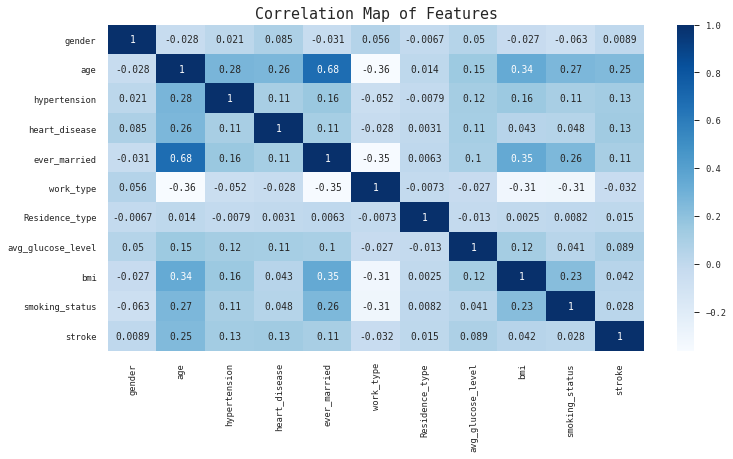

In [34]:
from sklearn.preprocessing import LabelEncoder
#  Using Lable encoding
le = LabelEncoder()
en_df = data.apply(le.fit_transform)
en_df.head()
sns.heatmap(en_df.corr(), cmap='Blues', annot=True)
plt.title('Correlation Map of Features', size=15);

## Model Training and Evaluation

In [35]:
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ( f1_score, classification_report, 
                             confusion_matrix, roc_auc_score,
                             roc_curve, auc ) 

One Hot encoding for categorical features

In [36]:
for feat in cat_feat:
    data = pd.get_dummies(columns=[feat], data=data, dtype=np.int64)
print(data.shape)
data.head()

(5110, 24)


,age,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,hypertension_No,hypertension_Yes,heart_disease_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,228.69,36.600000,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,61,202.21,28.893237,1,1,0,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
2,80,105.92,32.500000,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,49,171.23,34.400000,1,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
4,79,174.12,24.000000,1,1,0,0,0,1,1,...,0,0,1,0,1,0,0,0,1,0


Get features $X$ and target $y$ from dataset

In [37]:
y = data.stroke
X = data.drop('stroke', axis=1)
print(X.shape, y.shape)

(5110, 23) (5110,)


In [38]:
counter = Counter(y)
print('Target class distribution: {}'.format(
    {k: v for k, v in counter.items()}))

Target class distribution: {1: 249, 0: 4861}


Dataset is highly imblanced, we use StratifiedKFold to split the data. StratifiedKFold splits a dataset randomly, although in such a way that maintains the same class distribution in each subset.

### Helper Functions

In [39]:
# store results for result comparison
Model = []
F1score = []
AUCROC = [] 

In [134]:
def fit_predict(model, X, y, K, plot=True, sampling=False, show=False):
    ''' Description
        -----------
        Train model specified on dataset using StratifiedKFold
        and resampling (optional)
        
        Parameters
        ----------
        model : sklearn model
            Machine learning model to be trained 
        X : pandas dataframe
          Training dataset
        y : pandas series 
          Target column, must have same number of observations with X
        K : int
          Number of folds for StratifiedKFold
        plot : bool, optional
          Show roc-auc training plot (optional)
        sampling : bool, optional
          Use resample data for training 
        show: bool, optional
          Print number of observations after resampling
          
        Returns
        --------
        average confusion matrix, classification report, model name
        and roc curve
    '''
    
    # set initial scores
    scores = 0
    auc_scores = 0
    # set empty list to store predictions on test set
    test_oofs = []
    # get model name
    model_name = type(model).__name__
    # set a zero matrix of shape (2,2) for confusion matrix
    matrix = np.zeros((2, 2))
    # set up empty lists to extend true and predicted values
    originalclass = []
    predictedclass = []
    probclass = []
    train_accuracies, test_accuracies = [0.5], [0.5]

    # initiate StratifiedKFold
    kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)

    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if sampling:
            # oversampling and undersampling 
            # define pipeline
            over = SMOTE(sampling_strategy=0.1, random_state=1)
            under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
            steps = [('o', over), ('u', under)]
            pipeline = Pipeline(steps=steps)

            # resample train dataset
            X_train, y_train = pipeline.fit_resample(X_train, y_train)
        
        # training
        if model_name in ['VotingClassifier', 'RandomForestClassifier']:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train,
                      early_stopping_rounds=300,
                      eval_set=[(X_test, y_test)],
                      verbose=False)
            
        # predicting on test set
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:, 1]
        # predict on train test
        train_prob = model.predict_proba(X_train)[:, 1]
        # append y_test and pred list to original class and predicted class
        # lists respectively
        originalclass.extend(y_test)
        predictedclass.extend(pred)
        probclass.extend(prob)
        # get F1-score and roc_auc_score
        score = f1_score(y_test, pred, average='macro')
        roc = roc_auc_score(y_test, prob)
        train_roc = roc_auc_score(y_train, train_prob)
        # append roc-auc for train and test
        train_accuracies.append(train_roc)
        test_accuracies.append(roc)
        # take mean of scores
        scores += score/K
        auc_scores += roc/K
        test_oofs.append(pred)
        # sum confusion matrix of each fold to matrix
        matrix += confusion_matrix(y_test, pred)

        if i % 4 == 0:
            print('Fold {} F1-score: {}'.format(i+1, score))
            print('Fold {} ROC-AUC score: {}'.format(i+1, roc))
            print('='*45)

    print()
    print('Avg F1 score: {:.4f} '.format(scores))
    print('Avg ROC-AUC score: {:.4f} '.format(auc_scores))
    
    if show:
        counter = Counter(y_train)
        print('Target class distribution after sampling: {}'.format(
        {k: v for k, v in counter.items()})) 
        print()
        
    if plot:
        # plot train and test roc-auc
        plt.figure(figsize=(10, 5))
        plt.plot(train_accuracies, label="train roc-auc")
        plt.plot(test_accuracies, label="test roc-auc")
        plt.legend(loc="lower right", prop={'size': 12})
        plt.xticks(range(0, K, 5))
        plt.xlabel("fold", size=12)
        plt.ylabel("roc-auc", size=12)
        plt.show() 

    # get classification report
    report = classification_report(originalclass, predictedclass)
    curve_ = roc_curve(originalclass, probclass)

    # append results for comaprison
    Model.append(model_name)  # model name
    F1score.append(scores)  # f1-score
    AUCROC.append(auc_scores)  # roc_auc_score

    return matrix, report,  model, curve_

In [142]:
plt.plot?

In [125]:
def importance_plot(model, X, sample=''):
    ''' Description: Creates feature importance plot for a trained model
        Arguements: model - trained model on dataset
                    X - training dataset
                    sample - sampling method
    '''
    model_name = type(model).__name__
    if model_name in ['LogisticRegression', 'LinearRegression']:
        feat_imp = pd.DataFrame(sorted(zip(model.coef_[0], X.columns)),
                                columns=['Value', 'Feature'])
    else:
        feat_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)),
                                columns=['Value', 'Feature'])
    plt.figure(figsize=(20, 15))
    imp_data = feat_imp.sort_values(by="Value", ascending=False)
    sns.barplot(x="Value", y="Feature", data=imp_data.iloc[:50])
    plt.ylabel('Feature Importance Score')
    plt.title(model_name + ' + ' + sample + ' Feature Importance', size=15)
    plt.show()

In [129]:
def heat_map(model, matrix, labels, sample=''):
    ''' Description: Creates confusion matrix heatmap for a model
        Arguements: model - trained model
                    matrix - model confusion matrix
                    labels - list containing class labels [0, 1]
    '''
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,
                annot=True, fmt='g')
    plt.xlabel('Predicted label', size=10)
    plt.ylabel('True label', size=10)
    plt.title(type(model).__name__ + ' + ' + sample + ' Confusion Matrix Heatmap', size=15)
    plt.show()

### Train and Evaluate

Fold 1 F1-score: 0.4875
Fold 1 ROC-AUC score: 0.8082051282051281
Fold 5 F1-score: 0.4875
Fold 5 ROC-AUC score: 0.8041025641025641
Fold 9 F1-score: 0.4875
Fold 9 ROC-AUC score: 0.8858974358974359
Fold 13 F1-score: 0.48743718592964824
Fold 13 ROC-AUC score: 0.8768041237113402
Fold 17 F1-score: 0.4848484848484848
Fold 17 ROC-AUC score: 0.8268041237113402
Fold 21 F1-score: 0.5707070707070707
Fold 21 ROC-AUC score: 0.8840206185567011
Fold 25 F1-score: 0.5899497487437186
Fold 25 ROC-AUC score: 0.8558404558404559

Avg F1 score: 0.5109 
Avg ROC-AUC score: 0.8506 


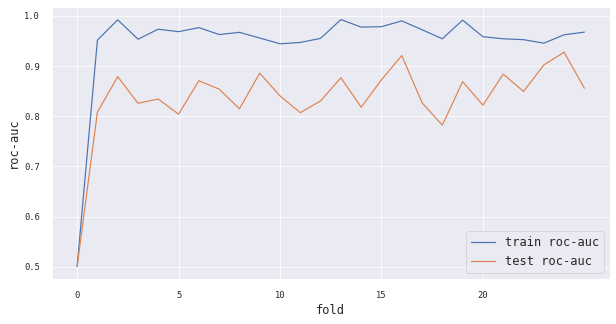

In [137]:
xgboost = xgb.XGBClassifier(eval_metric='logloss')
xgb_matrix, xgb_report, xgb_1, xgb_curve = fit_predict(xgboost, X, y, 25)

Feature importance plot

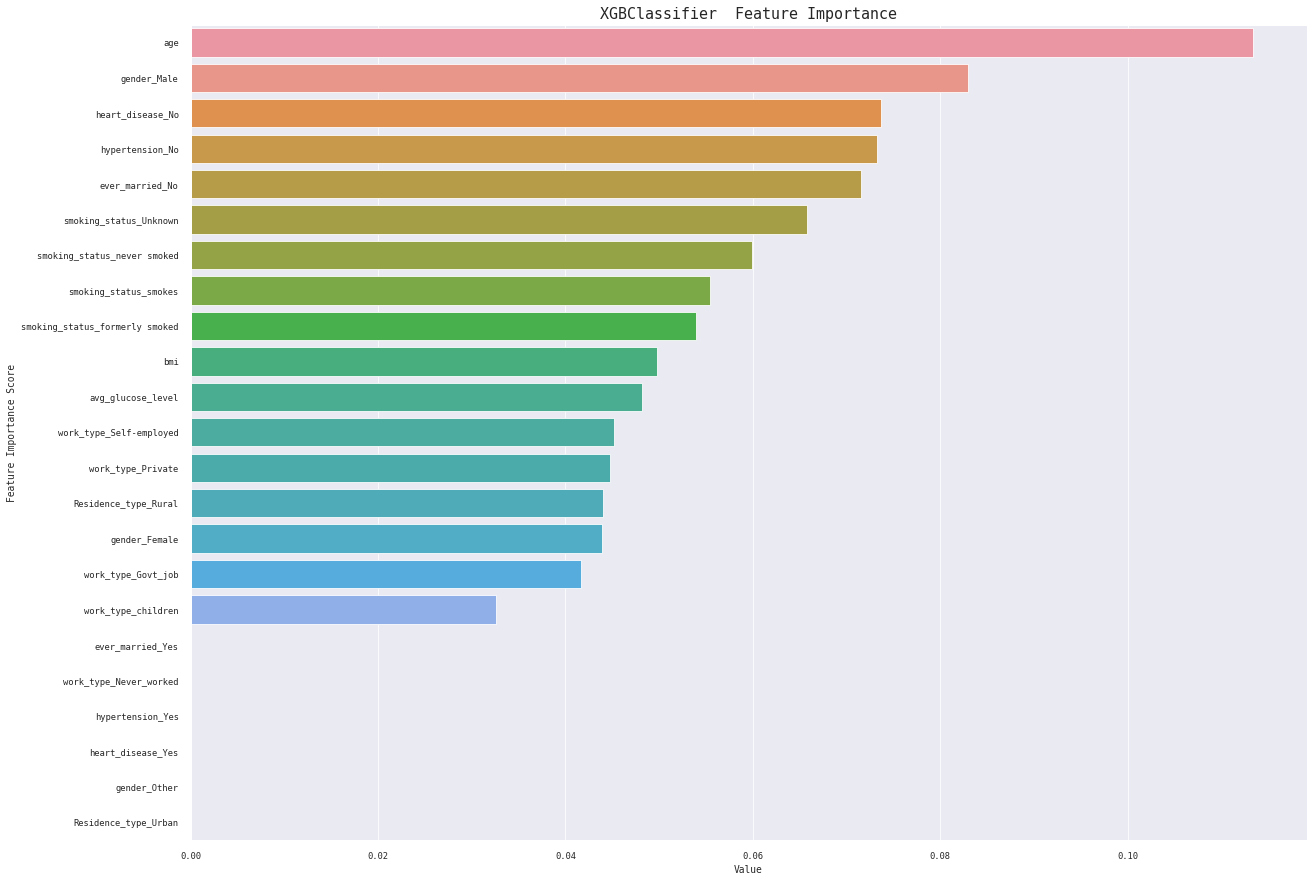

In [112]:
importance_plot(xgb_1, X)

Confusion matrix heatmap

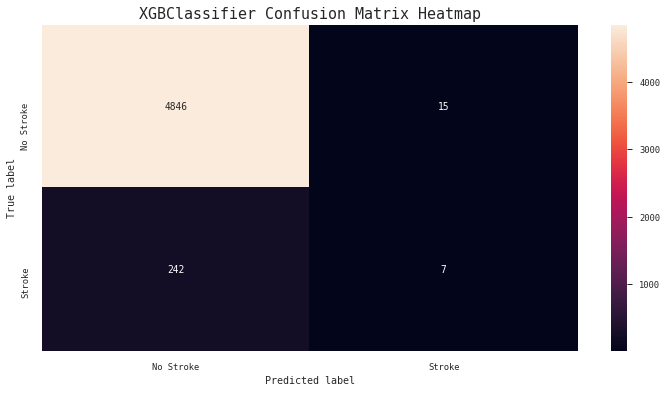

In [113]:
heat_map(xgb_1, xgb_matrix, ['No Stroke', 'Stroke'])

In [63]:
print(xgb_report) 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4861
           1       0.32      0.03      0.05       249

    accuracy                           0.95      5110
   macro avg       0.64      0.51      0.51      5110
weighted avg       0.92      0.95      0.93      5110



ROC Curve

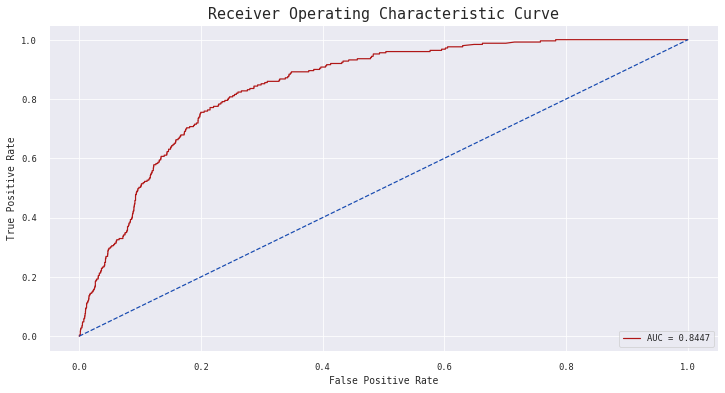

In [64]:
# Roc Curve
fpr, tpr, _ = xgb_curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = '#b01717', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic Curve', size=15); 

#### Hyperparameter tuning

In [65]:
import optuna

In [66]:
def objective(trial):
    kf = StratifiedKFold(10)
    
    for train_index, valid_index in kf.split(X, y):
        train_x, val_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, val_y = y.iloc[train_index], y.iloc[valid_index]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    accuracy = roc_auc_score(val_y, preds)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-08-10 16:31:00,116] A new study created in memory with name: no-name-fe17816f-e0b1-46b7-b4e5-d6d89569f908
[I 2021-08-10 16:31:00,195] Trial 0 finished with value: 0.31091718001368923 and parameters: {'n_estimators': 3418, 'learning_rate': 0.08732233094233459, 'booster': 'gblinear', 'lambda': 0.22269132351434104, 'alpha': 1.5899092807806256e-07}. Best is trial 0 with value: 0.31091718001368923.
[I 2021-08-10 16:31:00,245] Trial 1 finished with value: 0.5745208761122519 and parameters: {'n_estimators': 2121, 'learning_rate': 0.06387304626670799, 'booster': 'gblinear', 'lambda': 0.0024615016943375784, 'alpha': 0.005160460181551027}. Best is trial 1 with value: 0.5745208761122519.
[I 2021-08-10 16:31:00,405] Trial 2 finished with value: 0.810361054072553 and parameters: {'n_estimators': 3143, 'learning_rate': 0.044160957230797195, 'booster': 'dart', 'lambda': 0.8047769111380013, 'alpha': 1.0308984218525754e-05, 'max_depth': 8, 'eta': 8.440305220582089e-06, 'gamma': 0.79151465695149

[I 2021-08-10 16:31:02,465] Trial 19 finished with value: 0.8307238193018481 and parameters: {'n_estimators': 3640, 'learning_rate': 0.08139789718414217, 'booster': 'dart', 'lambda': 0.012926097619283023, 'alpha': 0.0003544117113887554, 'max_depth': 3, 'eta': 4.57469625862389e-07, 'gamma': 0.0004921773807724972, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.02774878354239816, 'skip_drop': 0.0029221008672694507}. Best is trial 18 with value: 0.832178302532512.
[I 2021-08-10 16:31:02,601] Trial 20 finished with value: 0.832178302532512 and parameters: {'n_estimators': 3769, 'learning_rate': 0.0852347156705092, 'booster': 'gbtree', 'lambda': 0.015370206643961985, 'alpha': 0.00010125690427636774, 'max_depth': 3, 'eta': 8.113306333860133e-08, 'gamma': 0.000922369524774359, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.832178302532512.
[I 2021-08-10 16:31:02,698] Trial 21 finished with value: 0.832178302532512 and parameters: {'

[I 2021-08-10 16:31:04,418] Trial 40 finished with value: 0.8261892539356606 and parameters: {'n_estimators': 3129, 'learning_rate': 0.0878285647505767, 'booster': 'gbtree', 'lambda': 0.9122013595817342, 'alpha': 6.263015729405598e-05, 'max_depth': 2, 'eta': 6.3055545864095655e-06, 'gamma': 1.2316701510437347e-06, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.8337183436002737.
[I 2021-08-10 16:31:04,539] Trial 41 finished with value: 0.832178302532512 and parameters: {'n_estimators': 3427, 'learning_rate': 0.0856671894670335, 'booster': 'gbtree', 'lambda': 0.014103161943033155, 'alpha': 0.00019958063584231344, 'max_depth': 3, 'eta': 1.5113386895588855e-07, 'gamma': 0.0007168226270270621, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.8337183436002737.
[I 2021-08-10 16:31:04,621] Trial 42 finished with value: 0.8344883641341547 and parameters: {'n_estimators': 3835, 'learning_rate': 0.07734808657419295, 'booster': 'gbtree', 'lambda': 0.11780431638019173, 'alph

[I 2021-08-10 16:31:06,598] Trial 59 finished with value: 0.8185318275154004 and parameters: {'n_estimators': 4243, 'learning_rate': 0.058821074235608985, 'booster': 'dart', 'lambda': 0.4537342364425704, 'alpha': 8.184623105530702e-07, 'max_depth': 5, 'eta': 0.0001335695139713841, 'gamma': 0.00010108746567233746, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.042550705985308544, 'skip_drop': 2.346352235129419e-07}. Best is trial 54 with value: 0.8354295003422314.
[I 2021-08-10 16:31:06,680] Trial 60 finished with value: 0.8233658453114305 and parameters: {'n_estimators': 3840, 'learning_rate': 0.08209992057912306, 'booster': 'dart', 'lambda': 0.09066819126178285, 'alpha': 8.513492032616281e-06, 'max_depth': 2, 'eta': 0.001910722476312477, 'gamma': 1.0496546405918735e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 8.61966189957234e-06, 'skip_drop': 1.824455842661765e-06}. Best is trial 54 w

[I 2021-08-10 16:31:08,727] Trial 76 finished with value: 0.8236652977412732 and parameters: {'n_estimators': 1595, 'learning_rate': 0.0904615821078774, 'booster': 'dart', 'lambda': 0.30779200461962297, 'alpha': 0.00038622436468656654, 'max_depth': 4, 'eta': 0.05834971325348452, 'gamma': 7.022898366910913e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.4557467087255997e-06, 'skip_drop': 5.020003264952117e-06}. Best is trial 54 with value: 0.8354295003422314.
[I 2021-08-10 16:31:08,814] Trial 77 finished with value: 0.8191735112936345 and parameters: {'n_estimators': 1660, 'learning_rate': 0.08687868210215467, 'booster': 'dart', 'lambda': 0.6483838624226016, 'alpha': 0.004769445937365536, 'max_depth': 3, 'eta': 0.003018743022429715, 'gamma': 0.011483455093292086, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00014825619549983668, 'skip_drop': 0.0019068979185584544}. Best is trial 54 wit

[I 2021-08-10 16:31:10,384] Trial 96 finished with value: 0.8305527036276523 and parameters: {'n_estimators': 1818, 'learning_rate': 0.0789143738697389, 'booster': 'gbtree', 'lambda': 0.04122525106603605, 'alpha': 0.00015678377990356246, 'max_depth': 3, 'eta': 3.002331952795776e-08, 'gamma': 0.019813349569419717, 'grow_policy': 'lossguide'}. Best is trial 54 with value: 0.8354295003422314.
[I 2021-08-10 16:31:10,444] Trial 97 finished with value: 0.6806125941136209 and parameters: {'n_estimators': 1155, 'learning_rate': 0.08499123532123896, 'booster': 'gblinear', 'lambda': 0.006939568043724207, 'alpha': 0.0003231278283199572}. Best is trial 54 with value: 0.8354295003422314.
[I 2021-08-10 16:31:10,512] Trial 98 finished with value: 0.8347878165639974 and parameters: {'n_estimators': 1395, 'learning_rate': 0.08656971801101689, 'booster': 'gbtree', 'lambda': 0.27719363556430876, 'alpha': 0.0005047895431546495, 'max_depth': 3, 'eta': 1.4274221860003151e-08, 'gamma': 0.0010159652540824241,

Number of finished trials:  100
Best trial:
  Value: 0.8354295003422314
  Params: 
    n_estimators: 3692
    learning_rate: 0.08391170702450801
    booster: dart
    lambda: 0.35336606465163567
    alpha: 0.00014762138716256176
    max_depth: 3
    eta: 0.0003546442280751086
    gamma: 0.004851054176058507
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: tree
    rate_drop: 0.000744903579055989
    skip_drop: 5.715000072190143e-07


In [68]:
op_xgboost = xgb.XGBClassifier(n_estimators = 3692,
                               learning_rate = 0.08391170702450801,
                                booster = 'dart',
                                reg_lambda = 0.35336606465163567,
                                alpha = 0.00014762138716256176,
                                max_depth = 3,
                                eta = 0.0003546442280751086,
                                gamma = 0.004851054176058507,
                                grow_policy= 'depthwise',
                                sample_type= 'uniform',
                                normalize_type= 'tree',
                                rate_drop= 0.000744903579055989,
                                skip_drop= 5.715000072190143e-07)   

Fold 1 F1-score: 0.4875
Fold 1 ROC-AUC score: 0.8353846153846154
Fold 5 F1-score: 0.4875
Fold 5 ROC-AUC score: 0.8166666666666667
Fold 9 F1-score: 0.4875
Fold 9 ROC-AUC score: 0.878974358974359
Fold 13 F1-score: 0.48743718592964824
Fold 13 ROC-AUC score: 0.856701030927835
Fold 17 F1-score: 0.48743718592964824
Fold 17 ROC-AUC score: 0.8242268041237113
Fold 21 F1-score: 0.48743718592964824
Fold 21 ROC-AUC score: 0.8902061855670104
Fold 25 F1-score: 0.48872180451127817
Fold 25 ROC-AUC score: 0.849002849002849

Avg F1 score: 0.4945 
Avg ROC-AUC score: 0.8545 


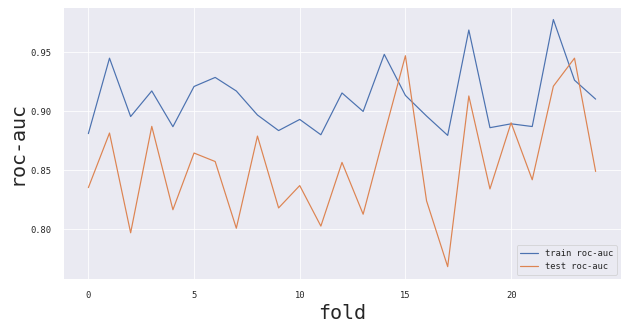

In [71]:
xgb_matrix_op, xgb_report_op, xgb_op, xgb_curve_op = fit_predict(op_xgboost, X, y, 25)

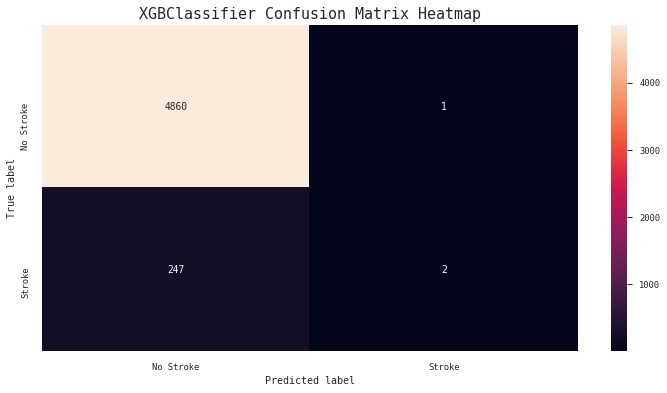

In [73]:
heat_map(xgb_op, xgb_matrix_op, ['No Stroke', 'Stroke'])

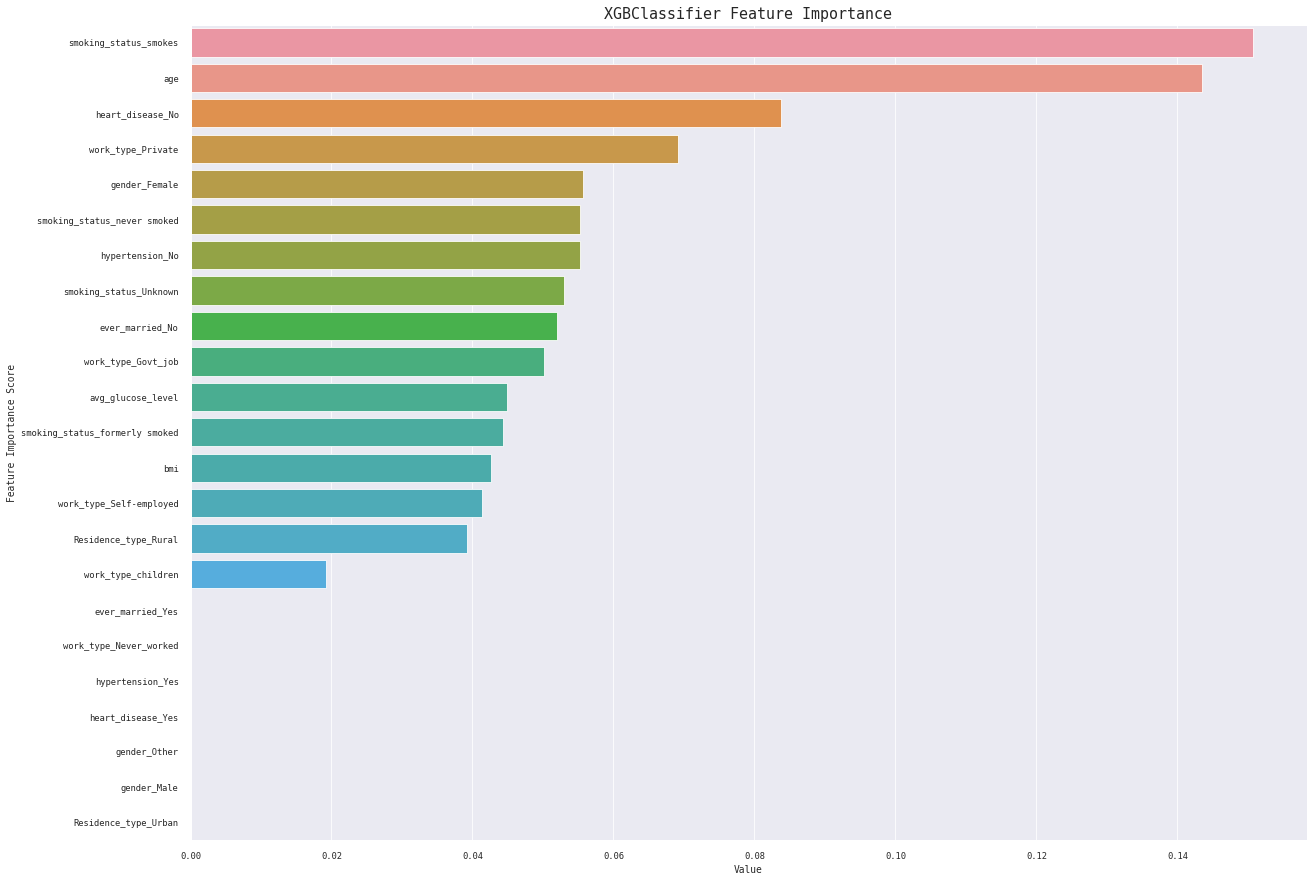

In [76]:
importance_plot(xgb_op, X)

In [78]:
print(xgb_report_op)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.67      0.01      0.02       249

    accuracy                           0.95      5110
   macro avg       0.81      0.50      0.50      5110
weighted avg       0.94      0.95      0.93      5110



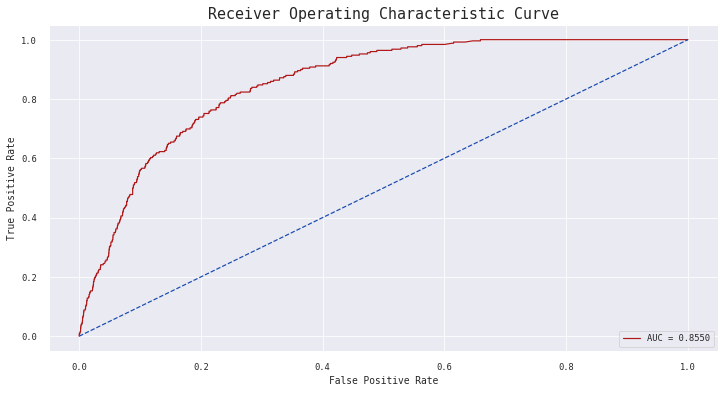

In [77]:
# Roc Curve
fpr, tpr, _ = xgb_curve_op
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = '#b01717', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic Curve', size=15); 

### Combine Oversampling and Random Undersampling

Since the dataset is imbalanced, we try to tackle this imbalance by oversampling the minority class and undersampling the majority class using random undersampling. Oversampling methods duplicate or create new synthetic examples in the minority class, whereas undersampling methods delete or merge examples in the majority class.

Train and evaluate using resampled data

In [52]:
Resample = [] 

Fold 1 F1-score: 0.6474794099013486
Fold 1 ROC-AUC score: 0.8353846153846154
Fold 5 F1-score: 0.5593584656084656
Fold 5 ROC-AUC score: 0.797948717948718
Fold 9 F1-score: 0.6551501035196687
Fold 9 ROC-AUC score: 0.8928205128205128
Fold 13 F1-score: 0.5892066049134113
Fold 13 ROC-AUC score: 0.8206185567010309
Fold 17 F1-score: 0.6344086021505377
Fold 17 ROC-AUC score: 0.8211340206185567
Fold 21 F1-score: 0.5565217391304348
Fold 21 ROC-AUC score: 0.7963917525773196
Fold 25 F1-score: 0.5508021390374331
Fold 25 ROC-AUC score: 0.8102564102564103

Avg F1 score: 0.6083 
Avg ROC-AUC score: 0.8349 
Target class distribution after sampling: {0: 932, 1: 466}



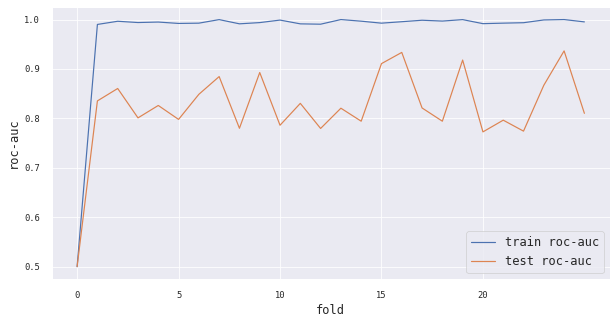

In [138]:
xgb_matrix_sample, xgb_report_sample, xgb_sample, xgb_curve_sample = fit_predict(xgboost, X, y, 
                                                                                25, sampling=True,
                                                                                show=True)

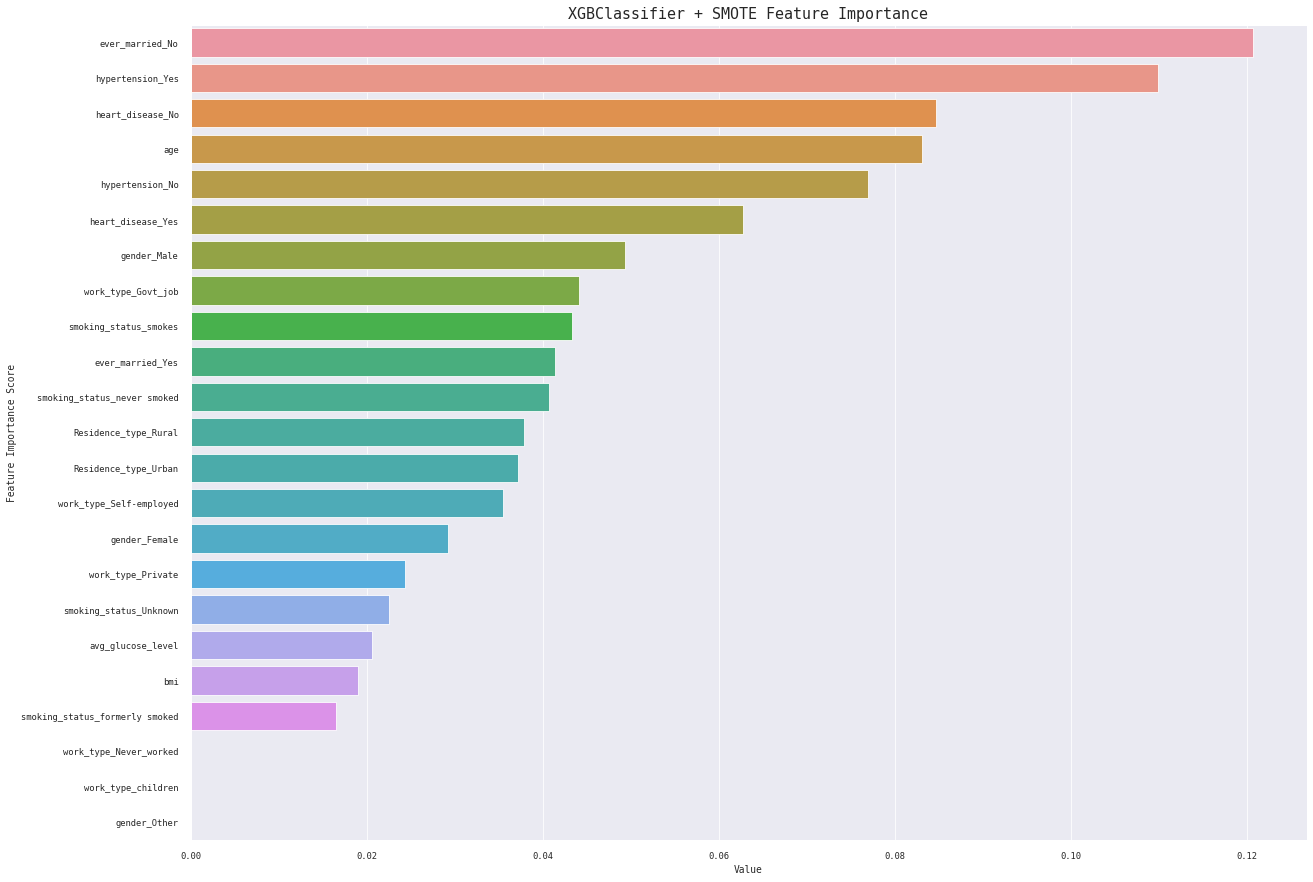

In [127]:
importance_plot(xgb_sample, X, 'SMOTE') 

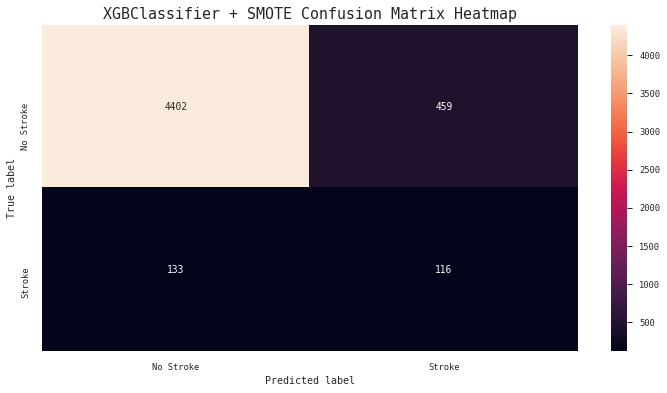

In [130]:
heat_map(xgb_sample, xgb_matrix_sample, ['No Stroke', 'Stroke'], 'SMOTE')

In [97]:
print(xgb_report_sample)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4861
           1       0.20      0.47      0.28       249

    accuracy                           0.88      5110
   macro avg       0.59      0.69      0.61      5110
weighted avg       0.93      0.88      0.91      5110



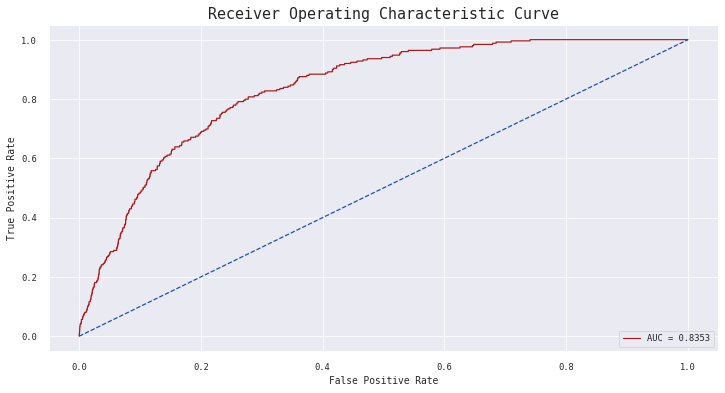

In [122]:
# Roc Curve
fpr, tpr, _ = xgb_curve_sample
roc_auc = auc(fpr, tpr) 

plt.plot(fpr, tpr, color = '#b01717', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic Curve', size=15); 